## Import Module

In [14]:
import argparse
import re
import os, glob, datetime, time
import numpy as np
import easydict
import cv2

import torch
import torch.nn as nn
from torch.nn.modules.loss import _Loss
import torch.nn.init as init
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR, ExponentialLR
from torch.utils.data import Dataset

from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
from skimage.io import imread, imsave
from sklearn.model_selection import train_test_split

## Define Model Constants

In [15]:
args = easydict.EasyDict({
    "model" : "DnCNN",
    "batch_size" : 32,
    "train_data" : 'Train_set',
    "origin_data" : 'Original_set',
    "epoch" : 200,
    "lr" : 1e-3
})

batch_size = args.batch_size
cuda = torch.cuda.is_available()
n_epoch = args.epoch

save_dir = os.path.join('models', args.model+'_' + 'compression')

if not os.path.exists(save_dir):
    os.mkdir(save_dir)

## Define Data Loader

In [16]:
patch_size, stride = 80, 60
aug_times = 1


class DenoisingDataset(Dataset):
    def __init__(self, ys, xs):
        super(DenoisingDataset, self).__init__()
        self.ys = ys # compression Noisy image
        self.xs = xs # original image
        

    def __getitem__(self, index):
        batch_x = self.xs[index] 
        batch_y = self.ys[index]
        
        return batch_y, batch_x

    def __len__(self):
        return self.xs.size(0)

    
def datagenerator_noise(data_dir, img_type):
    file_list = glob.glob(data_dir + '/*.' + img_type)
    data = []
    s = 0.8
    
    for i in range(len(file_list)):
        img = cv2.imread(file_list[i], 0)
        h, w = img.shape
        h_s, w_s = int(h*s), int(w*s)
        
        img = cv2.resize(img, (int(h/2), int(w/2)), interpolation = cv2.INTER_AREA) # 이미지 축소
        img = cv2.resize(img, (h, w), interpolation=cv2.INTER_CUBIC) # 이미지 확장
        
        img_re = cv2.resize(img, (w_s, w_s), interpolation=cv2.INTER_CUBIC)
        for j in range(0, w_s - patch_size + 1, stride):
            for k in range(0, w_s - patch_size + 1, stride):
                x = img_re[j:j+patch_size, k:k+patch_size]
                data.append(x)

    data = np.array(data, dtype = 'uint8')
    data = np.expand_dims(data, axis = 3)
    
    return data


def datagenerator_original(data_dir, img_type):
    file_list = glob.glob(data_dir + '/*.' + img_type)
    data = []
    s = 0.8
    
    for i in range(len(file_list)):
        img = cv2.imread(file_list[i], 0)
        h, w = img.shape
        h_s, w_s = int(h*s), int(w*s)
        
        img_re = cv2.resize(img, (w_s, w_s), interpolation=cv2.INTER_CUBIC)
        for j in range(0, w_s - patch_size + 1, stride):
            for k in range(0, w_s - patch_size + 1, stride):
                x = img_re[j:j+patch_size, k:k+patch_size]
                data.append(x)
    
    data = np.array(data, dtype = 'uint8')
    data = np.expand_dims(data, axis = 3)
    
    return data

## Define DnCNN Model

In [17]:
class DnCNN(nn.Module):
    
    def __init__(self, depth=19, n_channels=64, image_channels=1, use_bnorm=True, kernel_size=3):
        
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        self.depth = depth
        
        self.conv_relu_layers = nn.Sequential(
            nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=True),
            nn.ReLU(inplace=True)
        )

        self.conv_bn_relu_layers = nn.Sequential(
            nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=False),
            nn.BatchNorm2d(n_channels, eps=0.0001, momentum = 0.95),
            nn.ReLU(inplace=True)
        )
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=False)
        )

        self._initialize_weights()

    def forward(self, x):
        
        y = x
        
        out = self.conv_relu_layers(x)
        
        for _ in range(self.depth - 2):
            out = self.conv_bn_relu_layers(out)
        
        out = self.conv_layers(out)
        
        return y - out

    
    def _initialize_weights(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                print('init weight')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

## Define Function of Utility

In [18]:
def findLastCheckpoint(save_dir):
    file_list = glob.glob(os.path.join(save_dir, 'model_*.pth'))
    if file_list:
        epochs_exist = []
        for file_ in file_list:
            result = re.findall(".*model_(.*).pth.*", file_)
            epochs_exist.append(int(result[0]))
        initial_epoch = max(epochs_exist)
    else:
        initial_epoch = 0
    return initial_epoch


def log(*args, **kwargs):
     print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S:"), *args, **kwargs)

        
def save_result(result, path, ext):
    path = path
    ext = ext
    if ext in ('.txt', '.dlm'):
        np.savetxt(path, result, fmt='%2.4f')
    else:
        imsave(path, np.clip(result, 0, 1))

## Import Noise Dataset, Original Dataset & Split Training Set, Validation Set

In [19]:
noise_dataset = datagenerator_noise(args.train_data, 'png')
noise_dataset = noise_dataset.astype('float32')/255.0
noise_dataset = torch.from_numpy(noise_dataset.transpose((0, 3, 1, 2)))
    
target_dataset = datagenerator_original(args.origin_data, 'jpg')
target_dataset = target_dataset.astype('float32')/255.0
target_dataset = torch.from_numpy(target_dataset.transpose((0, 3, 1, 2)))


train_dataset, valid_dataset, train_target, valid_target = train_test_split(noise_dataset, target_dataset, test_size = 0.3)


train_target = train_target.numpy()
train_target = torch.from_numpy(train_target.transpose((0, 1, 3, 2)))


valid_target = valid_target.numpy()
valid_target = torch.from_numpy(valid_target.transpose((0, 1, 3, 2)))
    
Train_Dataset = DenoisingDataset(train_dataset, train_target)
DLoader = DataLoader(dataset = Train_Dataset, num_workers = 4, batch_size = batch_size, shuffle = True)

    
Validation_Dataset = DenoisingDataset(valid_dataset, valid_target)
VLoader = DataLoader(dataset = Validation_Dataset, num_workers = 4)

In [20]:
# Dataset Shape Check
noise_dataset.shape, target_dataset.shape, train_dataset.shape, train_target.shape, valid_dataset.shape, valid_target.shape

(torch.Size([35840, 1, 80, 80]),
 torch.Size([35840, 1, 80, 80]),
 torch.Size([25088, 1, 80, 80]),
 torch.Size([25088, 1, 80, 80]),
 torch.Size([10752, 1, 80, 80]),
 torch.Size([10752, 1, 80, 80]))

## Train Model

In [21]:
print('===> Building model')
model = DnCNN()
    
initial_epoch = findLastCheckpoint(save_dir=save_dir)  # load the last model in matconvnet style
    
if initial_epoch > 0:
    print('resuming by loading epoch %03d' % initial_epoch)
    model = torch.load(os.path.join(save_dir, 'model_%03d.pth' % initial_epoch))
    
    
criterion = nn.MSELoss(reduction = 'mean')
optimizer = optim.Adam(model.parameters(), lr=args.lr)

scheduler = ExponentialLR(optimizer, gamma = 0.5) # learning rates
    
psnr = []
ssim = []
train_loss = []
valid_loss = []


for epoch in range(initial_epoch, n_epoch):

    model.train()
        
    if cuda:
        model = model.cuda()
        
    psnr_epoch = []
    ssim_epoch = []

    scheduler.step(epoch)  # step to the learning rate in this epcoh
    epoch_loss = 0
    vloss = 0
    count = 0
    start_time = time.time()

    for n_count, batch_yx in enumerate(DLoader):
                
        optimizer.zero_grad()
                
        if cuda:
            batch_y, batch_x = batch_yx[0].cuda(), batch_yx[1].cuda()
            device = torch.device("cuda")
                
        torch.cuda.empty_cache()
        denoising = model(batch_y)
                
        loss = criterion(denoising, batch_x)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if n_count % 10 == 0:
            print('%4d %4d / %4d loss = %2.4f' % (epoch+1, n_count, train_dataset.size(0)//batch_size, loss.item()/batch_size))
        
        denoising = denoising.cpu()
        denoising = denoising.detach().numpy().astype(np.float32)
        
        batch_x = batch_x.cpu()
        batch_x = batch_x.detach().numpy().astype(np.float32)
        
        psnr_train = compare_psnr(batch_x, denoising, data_range = 2)
        #ssim_train = compare_ssim(batch_x, denoising, data_range = 2)
                
        psnr_epoch.append(psnr_train)
        #ssim_epoch.append(ssim_train)
        
    psnr.append(np.mean(psnr_epoch))
    #ssim.append(np.mean(ssim_epoch))
    elapsed_time = time.time() - start_time

    np.savetxt('train_result.txt', np.hstack((epoch+1, epoch_loss/n_count, elapsed_time)), fmt='%2.4f')
    torch.save(model, os.path.join(save_dir, 'model_%03d.pth' % (epoch+1)))
    
    torch.cuda.empty_cache()
    model.eval()
    
    with torch.no_grad():
        for y, x in VLoader:
            y = y.to(device)
            x = x.to(device)
            vloss += criterion(model(y), x)
            count+=1
    valid_loss.append(vloss/count)
    
    train_loss.append(epoch_loss/n_count)
    
    log('epoch = %4d , loss = %4.4f , validation loss = %4.4f , time = %4.2f s' % (epoch+1, epoch_loss/n_count, vloss/count, elapsed_time))
    
    save_result(psnr, path=os.path.join('Train_results', 'psnr_results.txt'), ext = '.txt')
    save_result(valid_loss, path=os.path.join('Train_results', 'valid_loss_results.txt'), ext = '.txt')
    save_result(train_loss, path=os.path.join('Train_results', 'train_loss_results.txt'), ext = '.txt')

===> Building model
init weight
init weight
init weight


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

   1    0 /  784 loss = 0.0133
   1   10 /  784 loss = 0.0044
   1   20 /  784 loss = 0.0030
   1   30 /  784 loss = 0.0029
   1   40 /  784 loss = 0.0025
   1   50 /  784 loss = 0.0022
   1   60 /  784 loss = 0.0027
   1   70 /  784 loss = 0.0024
   1   80 /  784 loss = 0.0031
   1   90 /  784 loss = 0.0026
   1  100 /  784 loss = 0.0027
   1  110 /  784 loss = 0.0025
   1  120 /  784 loss = 0.0025
   1  130 /  784 loss = 0.0018
   1  140 /  784 loss = 0.0024
   1  150 /  784 loss = 0.0020
   1  160 /  784 loss = 0.0025
   1  170 /  784 loss = 0.0018
   1  180 /  784 loss = 0.0028
   1  190 /  784 loss = 0.0027
   1  200 /  784 loss = 0.0025
   1  210 /  784 loss = 0.0021
   1  220 /  784 loss = 0.0027
   1  230 /  784 loss = 0.0020
   1  240 /  784 loss = 0.0025
   1  250 /  784 loss = 0.0020
   1  260 /  784 loss = 0.0026
   1  270 /  784 loss = 0.0021
   1  280 /  784 loss = 0.0026
   1  290 /  784 loss = 0.0023
   1  300 /  784 loss = 0.0021
   1  310 /  784 loss = 0.0022
   1  32

   4  190 /  784 loss = 0.0017
   4  200 /  784 loss = 0.0026
   4  210 /  784 loss = 0.0021
   4  220 /  784 loss = 0.0022
   4  230 /  784 loss = 0.0021
   4  240 /  784 loss = 0.0019
   4  250 /  784 loss = 0.0021
   4  260 /  784 loss = 0.0022
   4  270 /  784 loss = 0.0023
   4  280 /  784 loss = 0.0018
   4  290 /  784 loss = 0.0021
   4  300 /  784 loss = 0.0026
   4  310 /  784 loss = 0.0017
   4  320 /  784 loss = 0.0020
   4  330 /  784 loss = 0.0020
   4  340 /  784 loss = 0.0025
   4  350 /  784 loss = 0.0024
   4  360 /  784 loss = 0.0017
   4  370 /  784 loss = 0.0023
   4  380 /  784 loss = 0.0017
   4  390 /  784 loss = 0.0017
   4  400 /  784 loss = 0.0018
   4  410 /  784 loss = 0.0023
   4  420 /  784 loss = 0.0022
   4  430 /  784 loss = 0.0016
   4  440 /  784 loss = 0.0022
   4  450 /  784 loss = 0.0019
   4  460 /  784 loss = 0.0019
   4  470 /  784 loss = 0.0017
   4  480 /  784 loss = 0.0024
   4  490 /  784 loss = 0.0017
   4  500 /  784 loss = 0.0018
   4  51

   7  380 /  784 loss = 0.0017
   7  390 /  784 loss = 0.0018
   7  400 /  784 loss = 0.0024
   7  410 /  784 loss = 0.0021
   7  420 /  784 loss = 0.0022
   7  430 /  784 loss = 0.0022
   7  440 /  784 loss = 0.0017
   7  450 /  784 loss = 0.0021
   7  460 /  784 loss = 0.0021
   7  470 /  784 loss = 0.0023
   7  480 /  784 loss = 0.0026
   7  490 /  784 loss = 0.0023
   7  500 /  784 loss = 0.0020
   7  510 /  784 loss = 0.0025
   7  520 /  784 loss = 0.0022
   7  530 /  784 loss = 0.0021
   7  540 /  784 loss = 0.0019
   7  550 /  784 loss = 0.0023
   7  560 /  784 loss = 0.0020
   7  570 /  784 loss = 0.0020
   7  580 /  784 loss = 0.0017
   7  590 /  784 loss = 0.0023
   7  600 /  784 loss = 0.0023
   7  610 /  784 loss = 0.0020
   7  620 /  784 loss = 0.0023
   7  630 /  784 loss = 0.0023
   7  640 /  784 loss = 0.0024
   7  650 /  784 loss = 0.0021
   7  660 /  784 loss = 0.0022
   7  670 /  784 loss = 0.0028
   7  680 /  784 loss = 0.0019
   7  690 /  784 loss = 0.0022
   7  70

  10  570 /  784 loss = 0.0019
  10  580 /  784 loss = 0.0019
  10  590 /  784 loss = 0.0018
  10  600 /  784 loss = 0.0026
  10  610 /  784 loss = 0.0020
  10  620 /  784 loss = 0.0020
  10  630 /  784 loss = 0.0019
  10  640 /  784 loss = 0.0017
  10  650 /  784 loss = 0.0020
  10  660 /  784 loss = 0.0019
  10  670 /  784 loss = 0.0020
  10  680 /  784 loss = 0.0017
  10  690 /  784 loss = 0.0021
  10  700 /  784 loss = 0.0020
  10  710 /  784 loss = 0.0023
  10  720 /  784 loss = 0.0020
  10  730 /  784 loss = 0.0016
  10  740 /  784 loss = 0.0017
  10  750 /  784 loss = 0.0024
  10  760 /  784 loss = 0.0025
  10  770 /  784 loss = 0.0021
  10  780 /  784 loss = 0.0021
2021-12-18 11:24:31: epoch =   10 , loss = 0.0676 , validation loss = 0.1190 , time = 190.36 s
  11    0 /  784 loss = 0.0018
  11   10 /  784 loss = 0.0017
  11   20 /  784 loss = 0.0020
  11   30 /  784 loss = 0.0023
  11   40 /  784 loss = 0.0025
  11   50 /  784 loss = 0.0023
  11   60 /  784 loss = 0.0018
  11  

  13  760 /  784 loss = 0.0018
  13  770 /  784 loss = 0.0015
  13  780 /  784 loss = 0.0021
2021-12-18 11:35:46: epoch =   13 , loss = 0.0671 , validation loss = 0.1252 , time = 190.22 s
  14    0 /  784 loss = 0.0019
  14   10 /  784 loss = 0.0023
  14   20 /  784 loss = 0.0018
  14   30 /  784 loss = 0.0020
  14   40 /  784 loss = 0.0022
  14   50 /  784 loss = 0.0020
  14   60 /  784 loss = 0.0018
  14   70 /  784 loss = 0.0016
  14   80 /  784 loss = 0.0024
  14   90 /  784 loss = 0.0019
  14  100 /  784 loss = 0.0023
  14  110 /  784 loss = 0.0021
  14  120 /  784 loss = 0.0024
  14  130 /  784 loss = 0.0020
  14  140 /  784 loss = 0.0020
  14  150 /  784 loss = 0.0018
  14  160 /  784 loss = 0.0018
  14  170 /  784 loss = 0.0021
  14  180 /  784 loss = 0.0016
  14  190 /  784 loss = 0.0018
  14  200 /  784 loss = 0.0016
  14  210 /  784 loss = 0.0020
  14  220 /  784 loss = 0.0021
  14  230 /  784 loss = 0.0021
  14  240 /  784 loss = 0.0019
  14  250 /  784 loss = 0.0020
  14  

  17  130 /  784 loss = 0.0024
  17  140 /  784 loss = 0.0018
  17  150 /  784 loss = 0.0020
  17  160 /  784 loss = 0.0017
  17  170 /  784 loss = 0.0018
  17  180 /  784 loss = 0.0020
  17  190 /  784 loss = 0.0023
  17  200 /  784 loss = 0.0021
  17  210 /  784 loss = 0.0019
  17  220 /  784 loss = 0.0022
  17  230 /  784 loss = 0.0020
  17  240 /  784 loss = 0.0018
  17  250 /  784 loss = 0.0021
  17  260 /  784 loss = 0.0019
  17  270 /  784 loss = 0.0020
  17  280 /  784 loss = 0.0020
  17  290 /  784 loss = 0.0023
  17  300 /  784 loss = 0.0022
  17  310 /  784 loss = 0.0022
  17  320 /  784 loss = 0.0019
  17  330 /  784 loss = 0.0022
  17  340 /  784 loss = 0.0021
  17  350 /  784 loss = 0.0017
  17  360 /  784 loss = 0.0020
  17  370 /  784 loss = 0.0020
  17  380 /  784 loss = 0.0018
  17  390 /  784 loss = 0.0018
  17  400 /  784 loss = 0.0021
  17  410 /  784 loss = 0.0020
  17  420 /  784 loss = 0.0016
  17  430 /  784 loss = 0.0020
  17  440 /  784 loss = 0.0022
  17  45

  20  320 /  784 loss = 0.0026
  20  330 /  784 loss = 0.0021
  20  340 /  784 loss = 0.0016
  20  350 /  784 loss = 0.0025
  20  360 /  784 loss = 0.0018
  20  370 /  784 loss = 0.0019
  20  380 /  784 loss = 0.0024
  20  390 /  784 loss = 0.0018
  20  400 /  784 loss = 0.0024
  20  410 /  784 loss = 0.0019
  20  420 /  784 loss = 0.0019
  20  430 /  784 loss = 0.0019
  20  440 /  784 loss = 0.0017
  20  450 /  784 loss = 0.0019
  20  460 /  784 loss = 0.0021
  20  470 /  784 loss = 0.0023
  20  480 /  784 loss = 0.0022
  20  490 /  784 loss = 0.0028
  20  500 /  784 loss = 0.0019
  20  510 /  784 loss = 0.0019
  20  520 /  784 loss = 0.0023
  20  530 /  784 loss = 0.0020
  20  540 /  784 loss = 0.0022
  20  550 /  784 loss = 0.0022
  20  560 /  784 loss = 0.0016
  20  570 /  784 loss = 0.0021
  20  580 /  784 loss = 0.0019
  20  590 /  784 loss = 0.0021
  20  600 /  784 loss = 0.0022
  20  610 /  784 loss = 0.0018
  20  620 /  784 loss = 0.0022
  20  630 /  784 loss = 0.0018
  20  64

  23  510 /  784 loss = 0.0023
  23  520 /  784 loss = 0.0022
  23  530 /  784 loss = 0.0019
  23  540 /  784 loss = 0.0023
  23  550 /  784 loss = 0.0018
  23  560 /  784 loss = 0.0020
  23  570 /  784 loss = 0.0021
  23  580 /  784 loss = 0.0022
  23  590 /  784 loss = 0.0019
  23  600 /  784 loss = 0.0021
  23  610 /  784 loss = 0.0018
  23  620 /  784 loss = 0.0022
  23  630 /  784 loss = 0.0025
  23  640 /  784 loss = 0.0017
  23  650 /  784 loss = 0.0024
  23  660 /  784 loss = 0.0025
  23  670 /  784 loss = 0.0023
  23  680 /  784 loss = 0.0025
  23  690 /  784 loss = 0.0025
  23  700 /  784 loss = 0.0020
  23  710 /  784 loss = 0.0020
  23  720 /  784 loss = 0.0018
  23  730 /  784 loss = 0.0020
  23  740 /  784 loss = 0.0019
  23  750 /  784 loss = 0.0019
  23  760 /  784 loss = 0.0025
  23  770 /  784 loss = 0.0020
  23  780 /  784 loss = 0.0022
2021-12-18 12:13:22: epoch =   23 , loss = 0.0653 , validation loss = 0.1189 , time = 190.19 s
  24    0 /  784 loss = 0.0021
  24  

  26  700 /  784 loss = 0.0019
  26  710 /  784 loss = 0.0019
  26  720 /  784 loss = 0.0021
  26  730 /  784 loss = 0.0021
  26  740 /  784 loss = 0.0021
  26  750 /  784 loss = 0.0025
  26  760 /  784 loss = 0.0020
  26  770 /  784 loss = 0.0022
  26  780 /  784 loss = 0.0019
2021-12-18 12:24:39: epoch =   26 , loss = 0.0650 , validation loss = 0.1337 , time = 190.00 s
  27    0 /  784 loss = 0.0020
  27   10 /  784 loss = 0.0021
  27   20 /  784 loss = 0.0022
  27   30 /  784 loss = 0.0024
  27   40 /  784 loss = 0.0020
  27   50 /  784 loss = 0.0020
  27   60 /  784 loss = 0.0021
  27   70 /  784 loss = 0.0020
  27   80 /  784 loss = 0.0019
  27   90 /  784 loss = 0.0016
  27  100 /  784 loss = 0.0027
  27  110 /  784 loss = 0.0017
  27  120 /  784 loss = 0.0020
  27  130 /  784 loss = 0.0021
  27  140 /  784 loss = 0.0020
  27  150 /  784 loss = 0.0018
  27  160 /  784 loss = 0.0020
  27  170 /  784 loss = 0.0017
  27  180 /  784 loss = 0.0020
  27  190 /  784 loss = 0.0024
  27  

  30   70 /  784 loss = 0.0019
  30   80 /  784 loss = 0.0023
  30   90 /  784 loss = 0.0019
  30  100 /  784 loss = 0.0022
  30  110 /  784 loss = 0.0022
  30  120 /  784 loss = 0.0019
  30  130 /  784 loss = 0.0021
  30  140 /  784 loss = 0.0018
  30  150 /  784 loss = 0.0021
  30  160 /  784 loss = 0.0019
  30  170 /  784 loss = 0.0016
  30  180 /  784 loss = 0.0018
  30  190 /  784 loss = 0.0019
  30  200 /  784 loss = 0.0022
  30  210 /  784 loss = 0.0017
  30  220 /  784 loss = 0.0021
  30  230 /  784 loss = 0.0021
  30  240 /  784 loss = 0.0018
  30  250 /  784 loss = 0.0023
  30  260 /  784 loss = 0.0022
  30  270 /  784 loss = 0.0019
  30  280 /  784 loss = 0.0017
  30  290 /  784 loss = 0.0027
  30  300 /  784 loss = 0.0018
  30  310 /  784 loss = 0.0022
  30  320 /  784 loss = 0.0019
  30  330 /  784 loss = 0.0020
  30  340 /  784 loss = 0.0024
  30  350 /  784 loss = 0.0016
  30  360 /  784 loss = 0.0019
  30  370 /  784 loss = 0.0017
  30  380 /  784 loss = 0.0020
  30  39

  33  260 /  784 loss = 0.0018
  33  270 /  784 loss = 0.0023
  33  280 /  784 loss = 0.0022
  33  290 /  784 loss = 0.0017
  33  300 /  784 loss = 0.0026
  33  310 /  784 loss = 0.0020
  33  320 /  784 loss = 0.0018
  33  330 /  784 loss = 0.0022
  33  340 /  784 loss = 0.0019
  33  350 /  784 loss = 0.0018
  33  360 /  784 loss = 0.0022
  33  370 /  784 loss = 0.0023
  33  380 /  784 loss = 0.0021
  33  390 /  784 loss = 0.0015
  33  400 /  784 loss = 0.0019
  33  410 /  784 loss = 0.0022
  33  420 /  784 loss = 0.0018
  33  430 /  784 loss = 0.0019
  33  440 /  784 loss = 0.0021
  33  450 /  784 loss = 0.0022
  33  460 /  784 loss = 0.0023
  33  470 /  784 loss = 0.0027
  33  480 /  784 loss = 0.0024
  33  490 /  784 loss = 0.0020
  33  500 /  784 loss = 0.0017
  33  510 /  784 loss = 0.0021
  33  520 /  784 loss = 0.0022
  33  530 /  784 loss = 0.0026
  33  540 /  784 loss = 0.0021
  33  550 /  784 loss = 0.0017
  33  560 /  784 loss = 0.0023
  33  570 /  784 loss = 0.0022
  33  58

  36  450 /  784 loss = 0.0017
  36  460 /  784 loss = 0.0023
  36  470 /  784 loss = 0.0022
  36  480 /  784 loss = 0.0018
  36  490 /  784 loss = 0.0018
  36  500 /  784 loss = 0.0017
  36  510 /  784 loss = 0.0023
  36  520 /  784 loss = 0.0021
  36  530 /  784 loss = 0.0020
  36  540 /  784 loss = 0.0019
  36  550 /  784 loss = 0.0022
  36  560 /  784 loss = 0.0022
  36  570 /  784 loss = 0.0021
  36  580 /  784 loss = 0.0018
  36  590 /  784 loss = 0.0022
  36  600 /  784 loss = 0.0019
  36  610 /  784 loss = 0.0019
  36  620 /  784 loss = 0.0019
  36  630 /  784 loss = 0.0019
  36  640 /  784 loss = 0.0018
  36  650 /  784 loss = 0.0020
  36  660 /  784 loss = 0.0019
  36  670 /  784 loss = 0.0023
  36  680 /  784 loss = 0.0020
  36  690 /  784 loss = 0.0016
  36  700 /  784 loss = 0.0022
  36  710 /  784 loss = 0.0019
  36  720 /  784 loss = 0.0026
  36  730 /  784 loss = 0.0021
  36  740 /  784 loss = 0.0018
  36  750 /  784 loss = 0.0022
  36  760 /  784 loss = 0.0019
  36  77

  39  640 /  784 loss = 0.0019
  39  650 /  784 loss = 0.0020
  39  660 /  784 loss = 0.0017
  39  670 /  784 loss = 0.0018
  39  680 /  784 loss = 0.0020
  39  690 /  784 loss = 0.0019
  39  700 /  784 loss = 0.0025
  39  710 /  784 loss = 0.0024
  39  720 /  784 loss = 0.0019
  39  730 /  784 loss = 0.0023
  39  740 /  784 loss = 0.0018
  39  750 /  784 loss = 0.0019
  39  760 /  784 loss = 0.0021
  39  770 /  784 loss = 0.0023
  39  780 /  784 loss = 0.0017
2021-12-18 13:13:32: epoch =   39 , loss = 0.0648 , validation loss = 0.1229 , time = 190.22 s
  40    0 /  784 loss = 0.0016
  40   10 /  784 loss = 0.0023
  40   20 /  784 loss = 0.0021
  40   30 /  784 loss = 0.0019
  40   40 /  784 loss = 0.0020
  40   50 /  784 loss = 0.0020
  40   60 /  784 loss = 0.0015
  40   70 /  784 loss = 0.0018
  40   80 /  784 loss = 0.0019
  40   90 /  784 loss = 0.0019
  40  100 /  784 loss = 0.0022
  40  110 /  784 loss = 0.0016
  40  120 /  784 loss = 0.0019
  40  130 /  784 loss = 0.0023
  40  

  43   10 /  784 loss = 0.0021
  43   20 /  784 loss = 0.0021
  43   30 /  784 loss = 0.0018
  43   40 /  784 loss = 0.0017
  43   50 /  784 loss = 0.0021
  43   60 /  784 loss = 0.0021
  43   70 /  784 loss = 0.0019
  43   80 /  784 loss = 0.0019
  43   90 /  784 loss = 0.0019
  43  100 /  784 loss = 0.0020
  43  110 /  784 loss = 0.0021
  43  120 /  784 loss = 0.0020
  43  130 /  784 loss = 0.0022
  43  140 /  784 loss = 0.0017
  43  150 /  784 loss = 0.0020
  43  160 /  784 loss = 0.0023
  43  170 /  784 loss = 0.0017
  43  180 /  784 loss = 0.0018
  43  190 /  784 loss = 0.0020
  43  200 /  784 loss = 0.0024
  43  210 /  784 loss = 0.0023
  43  220 /  784 loss = 0.0022
  43  230 /  784 loss = 0.0022
  43  240 /  784 loss = 0.0023
  43  250 /  784 loss = 0.0024
  43  260 /  784 loss = 0.0016
  43  270 /  784 loss = 0.0022
  43  280 /  784 loss = 0.0022
  43  290 /  784 loss = 0.0017
  43  300 /  784 loss = 0.0023
  43  310 /  784 loss = 0.0022
  43  320 /  784 loss = 0.0020
  43  33

  46  200 /  784 loss = 0.0020
  46  210 /  784 loss = 0.0024
  46  220 /  784 loss = 0.0023
  46  230 /  784 loss = 0.0021
  46  240 /  784 loss = 0.0020
  46  250 /  784 loss = 0.0017
  46  260 /  784 loss = 0.0021
  46  270 /  784 loss = 0.0018
  46  280 /  784 loss = 0.0019
  46  290 /  784 loss = 0.0020
  46  300 /  784 loss = 0.0020
  46  310 /  784 loss = 0.0020
  46  320 /  784 loss = 0.0024
  46  330 /  784 loss = 0.0019
  46  340 /  784 loss = 0.0021
  46  350 /  784 loss = 0.0021
  46  360 /  784 loss = 0.0025
  46  370 /  784 loss = 0.0022
  46  380 /  784 loss = 0.0021
  46  390 /  784 loss = 0.0021
  46  400 /  784 loss = 0.0021
  46  410 /  784 loss = 0.0023
  46  420 /  784 loss = 0.0022
  46  430 /  784 loss = 0.0026
  46  440 /  784 loss = 0.0019
  46  450 /  784 loss = 0.0021
  46  460 /  784 loss = 0.0022
  46  470 /  784 loss = 0.0020
  46  480 /  784 loss = 0.0018
  46  490 /  784 loss = 0.0022
  46  500 /  784 loss = 0.0024
  46  510 /  784 loss = 0.0020
  46  52

  49  390 /  784 loss = 0.0020
  49  400 /  784 loss = 0.0021
  49  410 /  784 loss = 0.0021
  49  420 /  784 loss = 0.0020
  49  430 /  784 loss = 0.0020
  49  440 /  784 loss = 0.0022
  49  450 /  784 loss = 0.0021
  49  460 /  784 loss = 0.0019
  49  470 /  784 loss = 0.0020
  49  480 /  784 loss = 0.0020
  49  490 /  784 loss = 0.0017
  49  500 /  784 loss = 0.0020
  49  510 /  784 loss = 0.0020
  49  520 /  784 loss = 0.0019
  49  530 /  784 loss = 0.0024
  49  540 /  784 loss = 0.0018
  49  550 /  784 loss = 0.0018
  49  560 /  784 loss = 0.0021
  49  570 /  784 loss = 0.0023
  49  580 /  784 loss = 0.0020
  49  590 /  784 loss = 0.0021
  49  600 /  784 loss = 0.0025
  49  610 /  784 loss = 0.0022
  49  620 /  784 loss = 0.0020
  49  630 /  784 loss = 0.0016
  49  640 /  784 loss = 0.0020
  49  650 /  784 loss = 0.0017
  49  660 /  784 loss = 0.0021
  49  670 /  784 loss = 0.0022
  49  680 /  784 loss = 0.0018
  49  690 /  784 loss = 0.0021
  49  700 /  784 loss = 0.0020
  49  71

  52  580 /  784 loss = 0.0018
  52  590 /  784 loss = 0.0023
  52  600 /  784 loss = 0.0020
  52  610 /  784 loss = 0.0019
  52  620 /  784 loss = 0.0025
  52  630 /  784 loss = 0.0023
  52  640 /  784 loss = 0.0021
  52  650 /  784 loss = 0.0018
  52  660 /  784 loss = 0.0020
  52  670 /  784 loss = 0.0020
  52  680 /  784 loss = 0.0022
  52  690 /  784 loss = 0.0017
  52  700 /  784 loss = 0.0019
  52  710 /  784 loss = 0.0019
  52  720 /  784 loss = 0.0018
  52  730 /  784 loss = 0.0020
  52  740 /  784 loss = 0.0018
  52  750 /  784 loss = 0.0017
  52  760 /  784 loss = 0.0027
  52  770 /  784 loss = 0.0018
  52  780 /  784 loss = 0.0018
2021-12-18 14:02:28: epoch =   52 , loss = 0.0644 , validation loss = 0.1180 , time = 190.11 s
  53    0 /  784 loss = 0.0019
  53   10 /  784 loss = 0.0019
  53   20 /  784 loss = 0.0017
  53   30 /  784 loss = 0.0021
  53   40 /  784 loss = 0.0019
  53   50 /  784 loss = 0.0020
  53   60 /  784 loss = 0.0020
  53   70 /  784 loss = 0.0018
  53  

  55  770 /  784 loss = 0.0016
  55  780 /  784 loss = 0.0020
2021-12-18 14:13:46: epoch =   55 , loss = 0.0644 , validation loss = 0.1202 , time = 190.24 s
  56    0 /  784 loss = 0.0022
  56   10 /  784 loss = 0.0021
  56   20 /  784 loss = 0.0024
  56   30 /  784 loss = 0.0021
  56   40 /  784 loss = 0.0023
  56   50 /  784 loss = 0.0019
  56   60 /  784 loss = 0.0023
  56   70 /  784 loss = 0.0020
  56   80 /  784 loss = 0.0023
  56   90 /  784 loss = 0.0017
  56  100 /  784 loss = 0.0020
  56  110 /  784 loss = 0.0018
  56  120 /  784 loss = 0.0019
  56  130 /  784 loss = 0.0025
  56  140 /  784 loss = 0.0024
  56  150 /  784 loss = 0.0023
  56  160 /  784 loss = 0.0021
  56  170 /  784 loss = 0.0023
  56  180 /  784 loss = 0.0016
  56  190 /  784 loss = 0.0020
  56  200 /  784 loss = 0.0021
  56  210 /  784 loss = 0.0023
  56  220 /  784 loss = 0.0025
  56  230 /  784 loss = 0.0020
  56  240 /  784 loss = 0.0019
  56  250 /  784 loss = 0.0022
  56  260 /  784 loss = 0.0022
  56  

  59  140 /  784 loss = 0.0021
  59  150 /  784 loss = 0.0020
  59  160 /  784 loss = 0.0018
  59  170 /  784 loss = 0.0020
  59  180 /  784 loss = 0.0019
  59  190 /  784 loss = 0.0023
  59  200 /  784 loss = 0.0019
  59  210 /  784 loss = 0.0022
  59  220 /  784 loss = 0.0019
  59  230 /  784 loss = 0.0022
  59  240 /  784 loss = 0.0019
  59  250 /  784 loss = 0.0019
  59  260 /  784 loss = 0.0022
  59  270 /  784 loss = 0.0019
  59  280 /  784 loss = 0.0020
  59  290 /  784 loss = 0.0022
  59  300 /  784 loss = 0.0018
  59  310 /  784 loss = 0.0021
  59  320 /  784 loss = 0.0021
  59  330 /  784 loss = 0.0022
  59  340 /  784 loss = 0.0021
  59  350 /  784 loss = 0.0028
  59  360 /  784 loss = 0.0025
  59  370 /  784 loss = 0.0021
  59  380 /  784 loss = 0.0019
  59  390 /  784 loss = 0.0020
  59  400 /  784 loss = 0.0020
  59  410 /  784 loss = 0.0020
  59  420 /  784 loss = 0.0021
  59  430 /  784 loss = 0.0019
  59  440 /  784 loss = 0.0023
  59  450 /  784 loss = 0.0019
  59  46

  62  330 /  784 loss = 0.0022
  62  340 /  784 loss = 0.0024
  62  350 /  784 loss = 0.0018
  62  360 /  784 loss = 0.0021
  62  370 /  784 loss = 0.0023
  62  380 /  784 loss = 0.0019
  62  390 /  784 loss = 0.0021
  62  400 /  784 loss = 0.0021
  62  410 /  784 loss = 0.0021
  62  420 /  784 loss = 0.0019
  62  430 /  784 loss = 0.0018
  62  440 /  784 loss = 0.0025
  62  450 /  784 loss = 0.0018
  62  460 /  784 loss = 0.0022
  62  470 /  784 loss = 0.0021
  62  480 /  784 loss = 0.0020
  62  490 /  784 loss = 0.0016
  62  500 /  784 loss = 0.0021
  62  510 /  784 loss = 0.0022
  62  520 /  784 loss = 0.0022
  62  530 /  784 loss = 0.0020
  62  540 /  784 loss = 0.0021
  62  550 /  784 loss = 0.0026
  62  560 /  784 loss = 0.0019
  62  570 /  784 loss = 0.0022
  62  580 /  784 loss = 0.0016
  62  590 /  784 loss = 0.0019
  62  600 /  784 loss = 0.0016
  62  610 /  784 loss = 0.0021
  62  620 /  784 loss = 0.0018
  62  630 /  784 loss = 0.0018
  62  640 /  784 loss = 0.0018
  62  65

  65  520 /  784 loss = 0.0021
  65  530 /  784 loss = 0.0021
  65  540 /  784 loss = 0.0018
  65  550 /  784 loss = 0.0021
  65  560 /  784 loss = 0.0023
  65  570 /  784 loss = 0.0020
  65  580 /  784 loss = 0.0018
  65  590 /  784 loss = 0.0022
  65  600 /  784 loss = 0.0020
  65  610 /  784 loss = 0.0018
  65  620 /  784 loss = 0.0018
  65  630 /  784 loss = 0.0021
  65  640 /  784 loss = 0.0019
  65  650 /  784 loss = 0.0018
  65  660 /  784 loss = 0.0023
  65  670 /  784 loss = 0.0021
  65  680 /  784 loss = 0.0020
  65  690 /  784 loss = 0.0022
  65  700 /  784 loss = 0.0015
  65  710 /  784 loss = 0.0021
  65  720 /  784 loss = 0.0017
  65  730 /  784 loss = 0.0020
  65  740 /  784 loss = 0.0021
  65  750 /  784 loss = 0.0020
  65  760 /  784 loss = 0.0022
  65  770 /  784 loss = 0.0020
  65  780 /  784 loss = 0.0020
2021-12-18 14:51:23: epoch =   65 , loss = 0.0642 , validation loss = 0.1095 , time = 189.99 s
  66    0 /  784 loss = 0.0018
  66   10 /  784 loss = 0.0021
  66  

  68  710 /  784 loss = 0.0019
  68  720 /  784 loss = 0.0019
  68  730 /  784 loss = 0.0017
  68  740 /  784 loss = 0.0018
  68  750 /  784 loss = 0.0020
  68  760 /  784 loss = 0.0022
  68  770 /  784 loss = 0.0025
  68  780 /  784 loss = 0.0019
2021-12-18 15:02:39: epoch =   68 , loss = 0.0642 , validation loss = 0.1042 , time = 190.09 s
  69    0 /  784 loss = 0.0019
  69   10 /  784 loss = 0.0015
  69   20 /  784 loss = 0.0024
  69   30 /  784 loss = 0.0018
  69   40 /  784 loss = 0.0018
  69   50 /  784 loss = 0.0024
  69   60 /  784 loss = 0.0022
  69   70 /  784 loss = 0.0020
  69   80 /  784 loss = 0.0020
  69   90 /  784 loss = 0.0018
  69  100 /  784 loss = 0.0020
  69  110 /  784 loss = 0.0022
  69  120 /  784 loss = 0.0020
  69  130 /  784 loss = 0.0024
  69  140 /  784 loss = 0.0020
  69  150 /  784 loss = 0.0021
  69  160 /  784 loss = 0.0019
  69  170 /  784 loss = 0.0018
  69  180 /  784 loss = 0.0020
  69  190 /  784 loss = 0.0023
  69  200 /  784 loss = 0.0017
  69  

  72   80 /  784 loss = 0.0022
  72   90 /  784 loss = 0.0019
  72  100 /  784 loss = 0.0017
  72  110 /  784 loss = 0.0020
  72  120 /  784 loss = 0.0020
  72  130 /  784 loss = 0.0023
  72  140 /  784 loss = 0.0020
  72  150 /  784 loss = 0.0017
  72  160 /  784 loss = 0.0019
  72  170 /  784 loss = 0.0022
  72  180 /  784 loss = 0.0021
  72  190 /  784 loss = 0.0017
  72  200 /  784 loss = 0.0021
  72  210 /  784 loss = 0.0022
  72  220 /  784 loss = 0.0017
  72  230 /  784 loss = 0.0021
  72  240 /  784 loss = 0.0017
  72  250 /  784 loss = 0.0024
  72  260 /  784 loss = 0.0017
  72  270 /  784 loss = 0.0018
  72  280 /  784 loss = 0.0017
  72  290 /  784 loss = 0.0022
  72  300 /  784 loss = 0.0017
  72  310 /  784 loss = 0.0021
  72  320 /  784 loss = 0.0021
  72  330 /  784 loss = 0.0022
  72  340 /  784 loss = 0.0024
  72  350 /  784 loss = 0.0017
  72  360 /  784 loss = 0.0021
  72  370 /  784 loss = 0.0019
  72  380 /  784 loss = 0.0022
  72  390 /  784 loss = 0.0020
  72  40

KeyboardInterrupt: 

## Plot Train Loss and Validation Loss

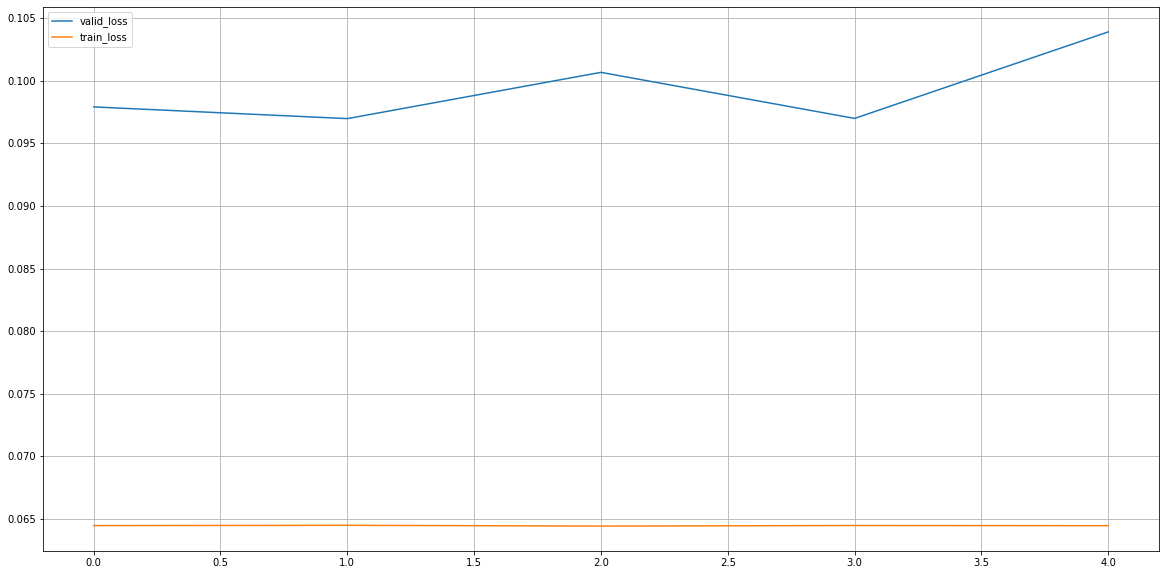

In [9]:
## 파일 추출해서 다른 ipynb 파일에서 Graph 작성 진행. Google Colab 환경에서 Graph plot.

#import matplotlib.pyplot as plt
#x = np.arange(0, len(valid_loss))
#plt.figure(figsize = (20, 10))
#plt.plot(x, valid_loss, x, train_loss)
#plt.grid()
#plt.legend(('valid_loss', 'train_loss'))

## Define Model Test Constants

In [22]:
def parse_args():

    args = easydict.EasyDict({
    "model_dir" : os.path.join('models', 'DnCNN_compression'),
    "Noise_set_dir" : 'Test_set/Test_set(Noise)',
    "Original_set_dir" : 'Test_set/Test_set(Original)',
    "model_name" : 'model_200.pth',
    "result_dir" : 'results',
    "save_result" : 1
    })
    return args

## Model Test and Save Test Result

In [23]:
args = parse_args()
device = torch.device("cuda")

if not os.path.exists(os.path.join(args.model_dir, args.model_name)):
    model = torch.load(os.path.join(args.model_dir, 'model.pth'))
    log('load trained model on Train400 dataset by kai')
else:
    model = torch.load(os.path.join(args.model_dir, args.model_name))
    log('load trained model')

model.eval()

if torch.cuda.is_available():
    model = model.cuda()

if not os.path.exists(args.result_dir):
    os.mkdir(args.result_dir)

test_psnrs = []
test_ssims = []

N_img_list = glob.glob(args.Noise_set_dir + '/*.png')
O_img_list = glob.glob(args.Original_set_dir + '/*.jpg')

for i in range(0, len(N_img_list)):
    if len(N_img_list) == len(O_img_list):
        
        y = np.array(cv2.imread(N_img_list[i], 0), dtype=np.float32)/255.0
        y = y.astype(np.float32)
        y_noise = torch.from_numpy(y).view(1, -1, y.shape[0], y.shape[1])
        
        x = np.array(cv2.imread(O_img_list[i], 0), dtype=np.float32)/255.0
    
        torch.cuda.synchronize()
        start_time = time.time()
        
        y_noise = y_noise.to(device)
        denoising = model(y_noise)
        denoising = denoising.view(y.shape[0], y.shape[1])
        denoising = denoising.cpu()
        denoising = denoising.detach().numpy().astype(np.float32)
    
        torch.cuda.synchronize()
        elapsed_time = time.time() - start_time
        print('%d epoch : %2.4f second' % (i + 1, elapsed_time))
    
        psnr_denoising = compare_psnr(x, denoising, data_range = 2)
        ssim_denoising = compare_ssim(x, denoising)
    
        if args.save_result:
            save_result(denoising, path = os.path.join('results', 'Compression_Denoising_Image_Result', str(i) + 'DnCNN_img.png'), ext = '.png')
    
        test_psnrs.append(psnr_denoising)
        test_ssims.append(ssim_denoising)

test_psnr_avg = np.mean(test_psnrs)
test_ssim_avg = np.mean(test_ssims)

test_psnrs.append(test_psnr_avg)
test_ssims.append(test_ssim_avg)

if args.save_result:
    save_result(test_psnrs, path=os.path.join('results', 'Compression_Denoising_Text_Result', 'psnr_results.txt'), ext = '.txt')
    save_result(test_ssims, path=os.path.join('results', 'Compression_Denoising_Text_Result', 'ssim_results.txt'), ext = '.txt')

log('Datset: {0:10s} \n  PSNR = {1:2.2f}dB, SSIM = {2:1.4f}'.format('Compression Noisy Image', test_psnr_avg, test_ssim_avg))

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


2021-12-18 15:27:03: load trained model
1 epoch : 0.1432 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


2 epoch : 0.1404 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


3 epoch : 0.0937 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


4 epoch : 0.0889 second
5 epoch : 0.0868 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


6 epoch : 0.0880 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


7 epoch : 0.0868 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


8 epoch : 0.0880 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


9 epoch : 0.0873 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


10 epoch : 0.0871 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


11 epoch : 0.0866 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


12 epoch : 0.0872 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


13 epoch : 0.0873 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


14 epoch : 0.0873 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


15 epoch : 0.0871 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


16 epoch : 0.0871 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


17 epoch : 0.0868 second
18 epoch : 0.0871 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


19 epoch : 0.0867 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


20 epoch : 0.0865 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


21 epoch : 0.0874 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


22 epoch : 0.0877 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


23 epoch : 0.0864 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


24 epoch : 0.0865 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


25 epoch : 0.0872 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


26 epoch : 0.0875 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


27 epoch : 0.0872 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


28 epoch : 0.0866 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


29 epoch : 0.0873 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


30 epoch : 0.0856 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


31 epoch : 0.0875 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


32 epoch : 0.0871 second
33 epoch : 0.0874 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


34 epoch : 0.0875 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


35 epoch : 0.0878 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


36 epoch : 0.0874 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


37 epoch : 0.0869 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


38 epoch : 0.0875 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


39 epoch : 0.0863 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


40 epoch : 0.0865 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


41 epoch : 0.0870 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


42 epoch : 0.0872 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


43 epoch : 0.0877 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


44 epoch : 0.0873 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


45 epoch : 0.0876 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


46 epoch : 0.0876 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


47 epoch : 0.0864 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


48 epoch : 0.0872 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


49 epoch : 0.0871 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


50 epoch : 0.0868 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


51 epoch : 0.0874 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


52 epoch : 0.0869 second
53 epoch : 0.0877 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


54 epoch : 0.0873 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


55 epoch : 0.0871 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


56 epoch : 0.0871 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


57 epoch : 0.0865 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


58 epoch : 0.0863 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


59 epoch : 0.0855 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


60 epoch : 0.0869 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


61 epoch : 0.0876 second
62 epoch : 0.0876 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


63 epoch : 0.0877 second
64 epoch : 0.0878 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


65 epoch : 0.0872 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


66 epoch : 0.0875 second
67 epoch : 0.0877 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


68 epoch : 0.0861 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


69 epoch : 0.0873 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


70 epoch : 0.0864 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


71 epoch : 0.0872 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


72 epoch : 0.0873 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


73 epoch : 0.0871 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


74 epoch : 0.0864 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


75 epoch : 0.0877 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


76 epoch : 0.0876 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


77 epoch : 0.0879 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


78 epoch : 0.0875 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


79 epoch : 0.0867 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


80 epoch : 0.0873 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


81 epoch : 0.0878 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


82 epoch : 0.0880 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


83 epoch : 0.0870 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


84 epoch : 0.0872 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


85 epoch : 0.0869 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


86 epoch : 0.0881 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


87 epoch : 0.1011 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


88 epoch : 0.0894 second
89 epoch : 0.0890 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


90 epoch : 0.0885 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


91 epoch : 0.0883 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


92 epoch : 0.0875 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


93 epoch : 0.0872 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


94 epoch : 0.0875 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


95 epoch : 0.0868 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


96 epoch : 0.0887 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


97 epoch : 0.0881 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


98 epoch : 0.0993 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


99 epoch : 0.0892 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


100 epoch : 0.0886 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


101 epoch : 0.0882 second
102 epoch : 0.0884 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


103 epoch : 0.0853 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


104 epoch : 0.0865 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


105 epoch : 0.0869 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


106 epoch : 0.0872 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


107 epoch : 0.0875 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


108 epoch : 0.0862 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


109 epoch : 0.0871 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


110 epoch : 0.0880 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


111 epoch : 0.0876 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


112 epoch : 0.0868 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


113 epoch : 0.0881 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


114 epoch : 0.0879 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


115 epoch : 0.0870 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


116 epoch : 0.0873 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


117 epoch : 0.0886 second
118 epoch : 0.0871 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


119 epoch : 0.0822 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


120 epoch : 0.0853 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


121 epoch : 0.0859 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


122 epoch : 0.0900 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


123 epoch : 0.0883 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


124 epoch : 0.0882 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


125 epoch : 0.0884 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


126 epoch : 0.0889 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


127 epoch : 0.0882 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


128 epoch : 0.0862 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


129 epoch : 0.0875 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


130 epoch : 0.0878 second
131 epoch : 0.0873 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


132 epoch : 0.0857 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


133 epoch : 0.0858 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


134 epoch : 0.0859 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


135 epoch : 0.0871 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


136 epoch : 0.0870 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


137 epoch : 0.0860 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


138 epoch : 0.0883 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


139 epoch : 0.0881 second


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


140 epoch : 0.0873 second
2021-12-18 15:28:07: Datset: Compression Noisy Image 
  PSNR = 17.19dB, SSIM = 0.4235
